<a href="https://colab.research.google.com/github/datawithnouman/hospital-readmission-prediction/blob/main/hospital_readmission_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Classification Report:

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.69      0.02      0.03      2271

    accuracy                           0.89     20354
   macro avg       0.79      0.51      0.49     20354
weighted avg       0.87      0.89      0.84     20354



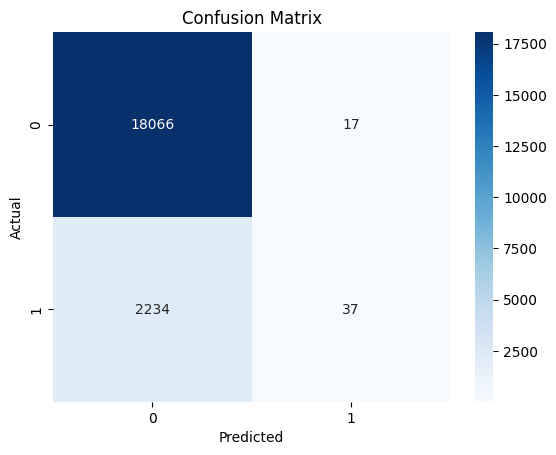

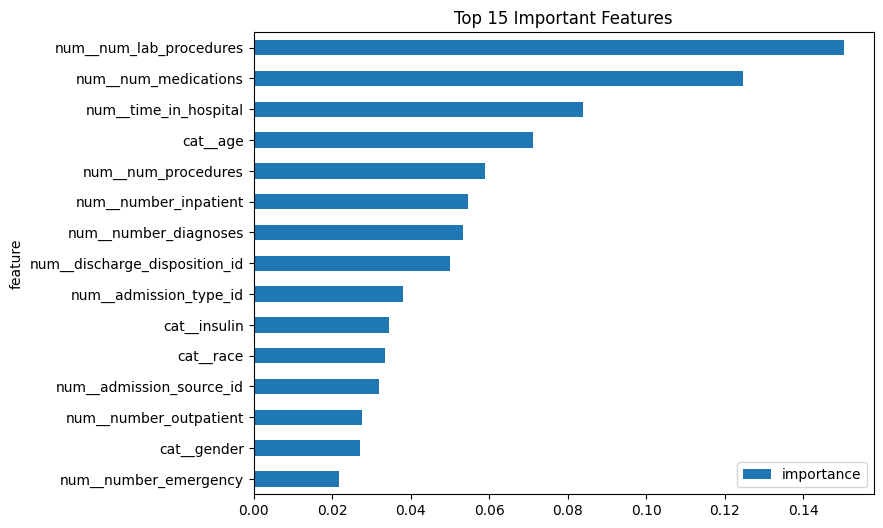

In [2]:


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("diabetic_data.csv")


columns_to_drop = ['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty',
                   'diag_1', 'diag_2', 'diag_3']
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')


df = df[df['readmitted'] != 'NA']


df['readmitted_binary'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)


X = df.drop(columns=['readmitted', 'readmitted_binary'])
y = df['readmitted_binary']

categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()


numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
pipeline.fit(X_train, y_train)


y_pred = pipeline.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


model = pipeline.named_steps['classifier']
importances = model.feature_importances_
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp_df.sort_values(by='importance', ascending=False).head(15).plot(
    x='feature', y='importance', kind='barh', figsize=(8, 6), title="Top 15 Important Features")
plt.gca().invert_yaxis()
plt.show()
